## 0. Init Environment, Timestamp & Branding

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform 
import random
import re
import sys
import unicodedata
import warnings

from datetime import datetime
from math import sqrt, log2
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")
print("Python:", sys.version)
print("Platform:", platform.platform())

DATA_DIR = Path("./data/")
OUTPUT_DIR = Path("./output/")
PLOTS_DIR = OUTPUT_DIR / "plots/"
MODELS_DIR = OUTPUT_DIR / "models/"
LOGS_DIR = OUTPUT_DIR / "logs/"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
random.seed(RANDOM_STATE); np.random.seed(RANDOM_STATE)
TS = datetime.now().strftime("%Y%m%d_%H%M%S")

p_info     = DATA_DIR / "hotel_info.csv"
p_comments = DATA_DIR / "hotel_comments.csv"
p_teencode = DATA_DIR / "teencode.txt"
p_stop     = DATA_DIR / "vietnamese-stopwords.txt"
p_emoji    = DATA_DIR / "emojicon.txt"
p_wrong    = DATA_DIR / "wrong-word.txt"
p_envi     = DATA_DIR / "english-vnmese.txt"

Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0


## 1. Load Data

In [2]:
def read_csv_safely(path, **kwargs):
    for enc in ["utf-8", "utf-8-sig", "cp1258", "latin-1"]:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except Exception as e:
            last_err = e
    raise last_err

def read_dict_txt(path, splitter=None):
    if not path.exists():
        return {}
    d = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            if splitter and splitter in line:
                k, v = line.split(splitter, 1)
                d[k.strip()] = v.strip()
            else:
                d[line] = ""
    return d

hotel_info     = read_csv_safely(p_info)
hotel_comments = read_csv_safely(p_comments)

teencode_map = read_dict_txt(p_teencode, splitter="\\t") or {}
stopwords    = set(read_dict_txt(p_stop).keys())
emoji_map    = read_dict_txt(p_emoji, splitter="\\t") or {}
wrong_map    = set(read_dict_txt(p_wrong).keys())
en_vi_map    = read_dict_txt(p_envi, splitter="\\t") or {}

print("hotel_info:", hotel_info.shape, "| hotel_comments:", hotel_comments.shape)
display(hotel_info.head(2)); display(hotel_comments.head(2))


hotel_info: (740, 14) | hotel_comments: (80314, 13)


,num,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,2,1_2,ALPHA BIRD NHA TRANG,4 sao trên 5,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...


,num,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022


## 2. Identify Key Columns & EDA

In [3]:
text_cols = [c for c in hotel_info.columns if re.search(r'(Hotel_Description)', c, re.I)]
id_cols   = [c for c in hotel_info.columns if re.search(r'(Hotel_ID)', c, re.I)]
name_cols = [c for c in hotel_info.columns if re.search(r'(Hotel_Name)', c, re.I)]
HOTEL_ID_COL   = id_cols[0] if id_cols else hotel_info.columns[0]
HOTEL_NAME_COL = name_cols[0] if name_cols else (hotel_info.columns[1] if hotel_info.shape[1] > 1 else HOTEL_ID_COL)

join_key = None
for c in [HOTEL_ID_COL, "Hotel ID"]:
    if c in hotel_comments.columns:
        join_key = c; break
print("JOIN KEY (comments->info):", join_key)

possible_rating_cols = [c for c in hotel_comments.columns if re.search(r'(Score)', c, re.I)]
user_cols = [c for c in hotel_comments.columns if re.search(r'(Reviewer Name)', c, re.I)]
user_col = user_cols[0] if user_cols else None
hotel_col = None
for c in [join_key, HOTEL_ID_COL, "Hotel_ID"]:
    if c and c in hotel_comments.columns:
        hotel_col = c; break

rating_col = None
for c in possible_rating_cols + ["Score"]:
    if c in hotel_comments.columns:
        rating_col = c; break

print("ALS columns -> user:", user_col, "| hotel:", hotel_col, "| rating:", rating_col)

print("ID:", HOTEL_ID_COL, "| NAME:", HOTEL_NAME_COL, "| JOIN:", join_key)
print("ALS columns -> user:", user_col, "| hotel:", hotel_col, "| rating:", rating_col)

JOIN KEY (comments->info): Hotel ID
ALS columns -> user: Reviewer Name | hotel: Hotel ID | rating: Score
ID: Hotel_ID | NAME: Hotel_Name | JOIN: Hotel ID
ALS columns -> user: Reviewer Name | hotel: Hotel ID | rating: Score


## 3 Vietnamese Text Preprocessing

In [4]:
def normalize_unicode(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return unicodedata.normalize("NFC", text)

def replace_emojis(text: str) -> str:
    for emo, meaning in emoji_map.items():
        text = text.replace(emo, f" {meaning} ")
    return text

def apply_teencode(text: str) -> str:
    toks = text.split()
    out = [teencode_map.get(tok, tok) for tok in toks]
    return " ".join(out)

def clean_text_basic(text: str) -> str:
    text = re.sub(r"http\\S+|www\\S+", " ", text)
    text = re.sub(r"[\\w.-]+@[\\w.-]+", " ", text)
    text = re.sub(r"\\d+", " ", text)
    text = re.sub(r"[^\\w\\sáàảãạăằắẳẵặâầấẩẫậéèẻẽẹêềếểễệíìỉĩịóòỏõọôồốổỗộơờớởỡợúùủũụưừứửữựýỳỷỹỵđ]", " ", text, flags=re.I)
    text = re.sub(r"\\s+", " ", text).strip()
    return text

def remove_wrong_tokens(text: str) -> str:
    toks = [t for t in text.split() if t not in wrong_map]
    return " ".join(toks)

def en_to_vi_single_tokens(text: str) -> str:
    toks = text.split()
    out = [en_vi_map.get(t.lower(), t) for t in toks]
    return " ".join(out)

def remove_stopwords(text: str) -> str:
    toks = [t for t in text.split() if t.lower() not in stopwords and len(t) > 1]
    return " ".join(toks)

def preprocess_vi(text: str) -> str:
    text = normalize_unicode(str(text).lower())
    text = replace_emojis(text)
    text = apply_teencode(text)
    text = clean_text_basic(text)
    text = remove_wrong_tokens(text)
    text = en_to_vi_single_tokens(text)
    text = remove_stopwords(text)
    return text

hotel_info["_text_info"]  = (hotel_info[text_cols].astype(str).agg(" ".join, axis=1) if text_cols else "")
hotel_comments["_merged_text"] = hotel_comments.select_dtypes(include=["object"]).astype(str).agg(" ".join, axis=1).map(preprocess_vi)
bag_reviews = {}
if join_key and join_key in hotel_comments.columns:
    bag_reviews = hotel_comments.groupby(join_key)["_merged_text"].apply(lambda s: " ".join(s.values.tolist())).to_dict()
hotel_info["_bag_reviews"] = hotel_info[HOTEL_ID_COL].map(bag_reviews).fillna("")
hotel_info["_corpus"] = (hotel_info["_text_info"].fillna("").map(preprocess_vi) + " " + hotel_info["_bag_reviews"].fillna(""))
print("Corpus prepared:", hotel_info["_corpus"].str.len().describe())

Corpus prepared: count      740.000000
mean      1783.562162
std       4602.001683
min          1.000000
25%         12.000000
50%         72.000000
75%       1014.250000
max      33057.000000
Name: _corpus, dtype: float64


## 4. Content-Based: TF-IDF / Doc2Vec / SBERT

In [5]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)
X_tfidf = tfidf.fit_transform(hotel_info["_corpus"])
COS_TFIDF = cosine_similarity(X_tfidf)

# Doc2Vec
D2V_EMB, COS_D2V = None, None
try:
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument
    documents = [TaggedDocument(words=row.split(), tags=[str(hid)]) 
                 for row, hid in zip(hotel_info["_corpus"].tolist(), hotel_info[HOTEL_ID_COL].astype(str).tolist())]
    d2v = Doc2Vec(vector_size=128, window=5, min_count=2, workers=4, epochs=30, dm=1)
    d2v.build_vocab(documents)
    d2v.train(documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)
    D2V_EMB = np.vstack([d2v.infer_vector(doc.words) for doc in documents])
    COS_D2V = cosine_similarity(D2V_EMB, D2V_EMB)
except Exception as e:
    print("Doc2Vec unavailable:", repr(e))

# SBERT
SBERT_EMB, COS_SBERT = None, None
try:
    from sentence_transformers import SentenceTransformer
    model_name = "paraphrase-multilingual-MiniLM-L12-v2"
    sbert_model = SentenceTransformer(model_name)
    SBERT_EMB = sbert_model.encode(hotel_info["_corpus"].tolist(), convert_to_numpy=True, show_progress_bar=False)
    COS_SBERT = cosine_similarity(SBERT_EMB, SBERT_EMB)
except Exception as e:
    print("SBERT unavailable:", repr(e))

try:
    if D2V_EMB is not None:
        np.save(MODELS_DIR / "d2v_emb.npy", D2V_EMB)
    if SBERT_EMB is not None:
        np.save(MODELS_DIR / "sbert_emb.npy", SBERT_EMB)
except Exception as e:
    print("Skip saving emb:", repr(e))

def recommend_from_sim(seed_hotel_id, sim_matrix, topn=10):
    if seed_hotel_id not in set(hotel_info[HOTEL_ID_COL]):
        raise ValueError("Hotel ID not found")
    idx = hotel_info.index[hotel_info[HOTEL_ID_COL] == seed_hotel_id][0]
    sims = sim_matrix[idx]
    order = np.argsort(-sims)[:topn+1]
    order = [i for i in order if i != idx][:topn]
    out = hotel_info.iloc[order][[HOTEL_ID_COL, HOTEL_NAME_COL]].copy()
    out["similarity"] = sims[order]
    return out

if len(hotel_info) > 1:
    demo_id = hotel_info.iloc[0][HOTEL_ID_COL]
    print("TF-IDF demo:"); display(recommend_from_sim(demo_id, COS_TFIDF, 5))
    if COS_D2V is not None: 
        print("Doc2Vec demo:"); display(recommend_from_sim(demo_id, COS_D2V, 5))
    if COS_SBERT is not None:
        print("SBERT demo:"); display(recommend_from_sim(demo_id, COS_SBERT, 5))

TF-IDF demo:


,Hotel_ID,Hotel_Name,similarity
233,21_8,Khách sạn Alana Nha Trang (Alana Nha Trang Bea...,0.932841
623,4_16,Khách sạn Dqua (DQua Hotel),0.925117
141,6_27,Vinpearl Beachfront Nha Trang,0.915213
7,1_8,Navada Beach Hotel,0.902252
241,22_7,Khách Sạn và Spa Emerald Bay (Emerald Bay Hote...,0.889396


Doc2Vec demo:


,Hotel_ID,Hotel_Name,similarity
69,3_10,Khách sạn Dendro Gold (Dendro Gold Hotel ),0.429979
188,15_27,Khách sạn Novotel Nha Trang (Novotel Nha Trang...,0.376017
294,33_9,"Căn hộ 42 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...",0.351610
64,3_5,TTC Van Phong Bay Resort,0.342884
233,21_8,Khách sạn Alana Nha Trang (Alana Nha Trang Bea...,0.330228


SBERT demo:


,Hotel_ID,Hotel_Name,similarity
14,1_15,Khách Sạn Erica Nha Trang (Erica Nha Trang Hotel),0.994349
164,13_8,DTX Hotel Nha Trang,0.993885
188,15_27,Khách sạn Novotel Nha Trang (Novotel Nha Trang...,0.992314
34,2_5,Khách sạn Boutique Seasing (Seasing Boutique H...,0.991968
78,3_19,Khách sạn Super OYO 598 Peony (Super OYO 598 P...,0.991938


## 5. Collaborative Filtering (Spark ALS) — Grid Search RMSE

In [6]:
assert rating_col is not None, "Score column not found."

def normalize_rating(series: pd.Series) -> pd.Series:

    s = series.astype(str).str.strip()
    s = s.replace({"": np.nan, "nan": np.nan, "None": np.nan, "N/A": np.nan, "na": np.nan})
    num = s.str.extract(r'([0-9]{1,3}(?:[.,][0-9]{1,2})?)', expand=False)
    num = num.str.replace(r'(?<=\d)\.(?=\d{3}(?:\D|$))', '', regex=True)
    num = num.str.replace(',', '.', regex=False)
    out = pd.to_numeric(num, errors='coerce').clip(lower=0, upper=10)
    return out

hotel_comments['__rating_clean'] = normalize_rating(hotel_comments[rating_col])
bad_mask = hotel_comments['__rating_clean'].isna() & hotel_comments[rating_col].notna()
print("Example of raw scoring that couldn’t be parsed:")
print(hotel_comments.loc[bad_mask, rating_col].drop_duplicates().head(10))

als_df = hotel_comments[[user_col, hotel_col, '__rating_clean']].dropna().copy()

if not np.issubdtype(als_df[user_col].dtype, np.number):
    als_df['__userId'] = pd.factorize(als_df[user_col])[0].astype('int32')
else:
    als_df['__userId'] = als_df[user_col].astype('int32')

if not np.issubdtype(als_df[hotel_col].dtype, np.number):
    als_df['__itemId'] = pd.factorize(als_df[hotel_col])[0].astype('int32')
else:
    als_df['__itemId'] = als_df[hotel_col].astype('int32')

als_df['__rating'] = als_df['__rating_clean'].astype('float32')

print("ALS dataframe shape:", als_df.shape)
als_df.head()

Example of raw scoring that couldn’t be parsed:
Series([], Name: Score, dtype: object)
ALS dataframe shape: (80228, 6)


,Reviewer Name,Hotel ID,__rating_clean,__userId,__itemId,__rating
0,MARIKO,1_1,10.0,0,0,10.0
1,Hong,1_1,10.0,1,0,10.0
2,Guai,1_1,9.2,2,0,9.2
3,Nghĩa,1_1,8.8,3,0,8.8
4,Duc,1_1,9.2,4,0,9.2


In [7]:
als_search_result = {"ok": False, "best": None, "trials": []}
BEST_ALS_MODEL = None

if not (user_col and hotel_col and rating_col):
    print("Insufficient columns to run ALS. Required: (user, hotel, score).")
else:
    try:

        import findspark
        findspark.init()

        from pyspark import SparkContext
        from pyspark.sql import functions as F, types as T
        from pyspark.sql import SparkSession
        from pyspark.sql.functions import *

        from pyspark.ml.recommendation import ALS
        from pyspark.ml.evaluation import RegressionEvaluator

        SparkContext.setSystemProperty('spark.hadoop.dfs.client.use.datanode.hostname', 'true')
        sc = SparkContext(master="local", appName="New Spark Context")
        sc.setLogLevel("ERROR")

        from pyspark.sql import SparkSession
        spark = SparkSession(sc)
        spark

        pdf = als_df[['__userId','__itemId','__rating']].copy()
        pdf['__userId'] = pdf['__userId'].astype('int64')
        pdf['__itemId'] = pdf['__itemId'].astype('int64')
        pdf['__rating'] = pdf['__rating'].astype('float64')

        sdf = spark.createDataFrame(pdf) \
            .withColumnRenamed('__userId','userId') \
            .withColumnRenamed('__itemId','itemId') \
            .withColumnRenamed('__rating','rating') \
            .select(
                F.col('userId').cast(T.IntegerType()),
                F.col('itemId').cast(T.IntegerType()),
                F.col('rating').cast(T.DoubleType())
            )

        print("Schema cho ALS:")
        sdf.printSchema()
        sdf.show(5, truncate=False)

        train, test = sdf.randomSplit([0.8, 0.2], seed=RANDOM_STATE)
        evaluator = RegressionEvaluator(
            metricName="rmse",
            labelCol="rating",
            predictionCol="prediction"
        )

        param_grid = {
            "rank": [10, 20, 40],
            "regParam": [0.01, 0.05, 0.1],
            "maxIter": [10, 15]
        }

        best = {"rmse": float("inf"), "params": None, "model": None}
        trial_id = 0

        for r in param_grid["rank"]:
            for reg in param_grid["regParam"]:
                for it in param_grid["maxIter"]:
                    trial_id += 1
                    als = ALS(
                        maxIter=it,
                        regParam=reg,
                        rank=r,
                        userCol="userId",
                        itemCol="itemId",
                        ratingCol="rating",
                        nonnegative=True,
                        coldStartStrategy="drop"
                    )

                    model = als.fit(train)
                    preds = model.transform(test)

                    preds = preds.filter(F.col("prediction").isNotNull())

                    print(f"[DBG] trial={trial_id} schema prediction:")
                    preds.select("userId","itemId","rating","prediction").printSchema()

                    rmse = evaluator.evaluate(preds)
                    als_search_result["trials"].append(
                        {"trial": trial_id, "rank": r, "regParam": reg, "maxIter": it, "rmse": rmse}
                    )
                    print(f"[Trial {trial_id}] rank={r} reg={reg} iter={it} -> RMSE={rmse:.4f}")

                    if rmse < best["rmse"]:
                        best = {"rmse": rmse, "params": {"rank": r, "regParam": reg, "maxIter": it}, "model": model}

        als_search_result["ok"] = True
        als_search_result["best"] = {"rmse": best["rmse"], "params": best["params"]}
        BEST_ALS_MODEL = best["model"]
        print("\nBest ALS:", als_search_result["best"])

        BEST_ALS_MODEL.write().overwrite().save(str(MODELS_DIR / "best_als_model"))
        pd.DataFrame(als_search_result["trials"]).to_csv(
            LOGS_DIR / f"als_gridsearch_results_{TS}.csv", index=False
        )
        sc.stop()
        spark.stop()

    except Exception as e:
        import traceback
        traceback.print_exc()
        print("Spark ALS is unavailable:", repr(e))
        sc.stop()
        spark.stop()

Schema cho ALS:
root
 |-- userId: integer (nullable = true)
 |-- itemId: integer (nullable = true)
 |-- rating: double (nullable = true)

+------+------+-----------------+
|userId|itemId|rating           |
+------+------+-----------------+
|0     |0     |10.0             |
|1     |0     |10.0             |
|2     |0     |9.199999809265137|
|3     |0     |8.800000190734863|
|4     |0     |9.199999809265137|
+------+------+-----------------+
only showing top 5 rows

[DBG] trial=1 schema prediction:
root
 |-- userId: integer (nullable = true)
 |-- itemId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- prediction: float (nullable = false)

[Trial 1] rank=10 reg=0.01 iter=10 -> RMSE=1.1177
[DBG] trial=2 schema prediction:
root
 |-- userId: integer (nullable = true)
 |-- itemId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- prediction: float (nullable = false)

[Trial 2] rank=10 reg=0.01 iter=15 -> RMSE=0.9813
[DBG] trial=3 schema prediction:
root

## 6. Evaluation + Bar Charts (PNG) + Markdown/PPTX Report 

,method,K,precision,map,ndcg_bin,ndcg_grd
0,doc2vec,5,0.502000,0.460000,0.033014,0.208884
3,sbert,5,0.631333,0.576556,0.045959,0.208561
6,tfidf,5,0.664000,0.623497,0.048380,0.286144
1,doc2vec,10,0.473667,0.418113,0.048596,0.205443
4,sbert,10,0.629333,0.557217,0.068753,0.220007
7,tfidf,10,0.666000,0.614360,0.072822,0.301156
2,doc2vec,20,0.442833,0.369407,0.070163,0.203721
5,sbert,20,0.632167,0.548042,0.104946,0.238145
8,tfidf,20,0.669833,0.607462,0.112158,0.318109


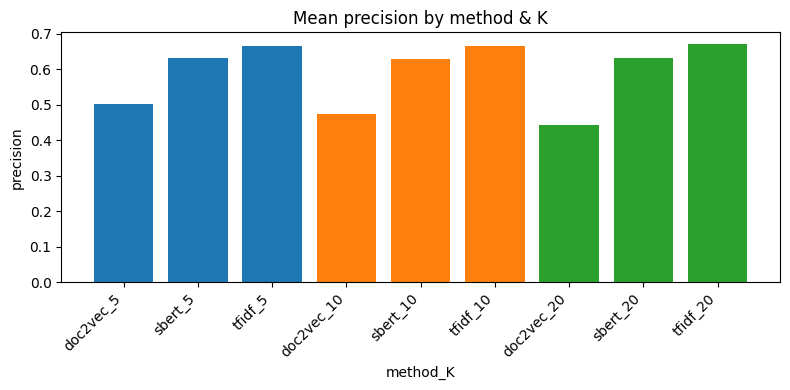

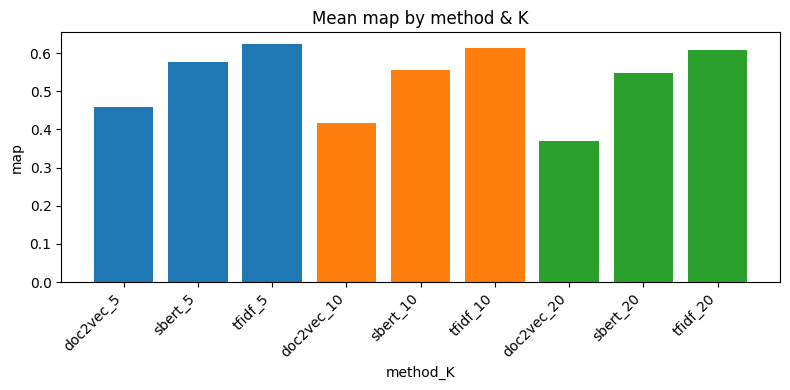

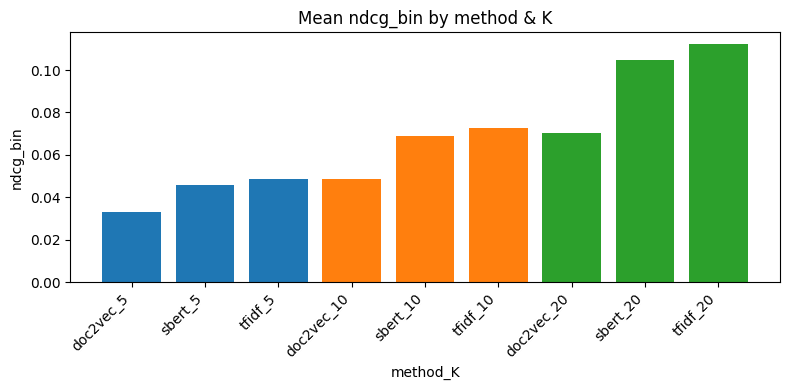

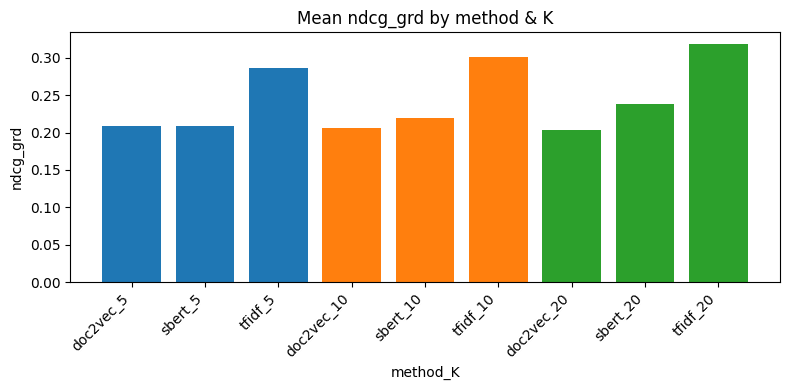

Saved charts: ['output\\plots\\precision.png', 'output\\plots\\map.png', 'output\\plots\\ndcg_bin.png', 'output\\plots\\ndcg_grd.png']
Wrote Markdown report: output\logs\Agoda_RS_Report_20250830_214903.md
Wrote PPTX report: output\logs\Agoda_RS_Report_20250830_214903.pptx


In [8]:
import builtins
try:
    from pyspark.sql import functions as F
    for _name in ("col", "map", "filter", "min", "max", "sum"):
        if _name in globals():
            try: del globals()[_name]
            except Exception: pass
except Exception:
    pass

def _py_min(a, b): return builtins.min(a, b)

N_SEEDS = 300
MIN_REL  = 2
K_LIST   = [5, 10, 20]

if not (user_col and hotel_col):
    raise RuntimeError("Missing user/hotel columns to create the Jaccard ground truth.")
df_pair = hotel_comments[[user_col, hotel_col]].dropna().drop_duplicates()
try:
    df_pair[hotel_col] = df_pair[hotel_col].astype(hotel_info[HOTEL_ID_COL].dtype)
except Exception:
    pass
users_by_hotel = df_pair.groupby(hotel_col)[user_col].apply(set).to_dict()
hotel_ids = hotel_info[HOTEL_ID_COL].tolist()

def jaccard_list(hid, topn=1000):
    u = users_by_hotel.get(hid, set())
    if not u: return []
    res = []
    for other, u2 in users_by_hotel.items():
        if other == hid: continue
        inter = len(u & u2)
        if inter == 0: continue
        union = len(u | u2)
        jac = inter / union if union else 0.0
        if jac > 0: res.append((other, float(jac)))
    res.sort(key=lambda x: x[1], reverse=True)
    return res[:topn]

candidates = [hid for hid in hotel_ids if len(jaccard_list(hid, 1000)) >= MIN_REL]
if not candidates:
    raise RuntimeError("No seeds meet the MIN_REL threshold for evaluation.")

k_seed = _py_min(N_SEEDS, len(candidates))
seeds = random.sample(candidates, k_seed)

def precision_at_k(recommended, relevant_set, k: int):
    rec = list(recommended)[:int(k)]
    rel = set(relevant_set)
    hits = sum(1 for x in rec if x in rel)
    return hits / builtins.max(int(k), 1)

def apk(recommended, relevant_set, k: int):
    rec = list(recommended)[:int(k)]
    rel = set(relevant_set)
    hits = 0
    score = 0.0
    for i, r in enumerate(rec, start=1):
        if r in rel:
            hits += 1
            score += hits / i
    return score / builtins.max(builtins.min(len(rel), int(k)), 1)

from math import log2
def ndcg_at_k_binary(recommended, relevant_set, k: int):
    rec = list(recommended)[:int(k)]
    rel = set(relevant_set)
    def dcg(items):
        s = 0.0
        for i, it in enumerate(items, start=1):
            s += (2.0**(1.0 if it in rel else 0.0) - 1.0) / log2(i + 1)
        return s
    dcg_val = dcg(rec)
    ideal = dcg(list(rel))
    return (dcg_val / ideal) if ideal > 0 else 0.0

def ndcg_at_k_graded(recommended, gains_dict, k: int):
    rec = list(recommended)[:int(k)]
    gains = dict(gains_dict)
    def dcg(items):
        s = 0.0
        for i, it in enumerate(items, start=1):
            rel = gains.get(it, 0.0)
            s += (2.0**rel - 1.0) / log2(i + 1)
        return s
    dcg_val = dcg(rec)
    ideal_items = [it for it, g in sorted(gains.items(), key=lambda x: x[1], reverse=True)]
    idcg = dcg(ideal_items[:int(k)])
    return (dcg_val / idcg) if idcg > 0 else 0.0

def topk_from_sim(sim_matrix, idx, topn):
    sims = sim_matrix[idx]
    order = np.argsort(-sims)[:topn+1]
    order = [i for i in order if i != idx][:topn]
    return hotel_info.iloc[order][HOTEL_ID_COL].tolist()

def eval_method(name, sim_matrix, topn=200):
    rows = []
    for hid in seeds:
        idx = id_to_idx.get(hid, None)
        if idx is None: 
            continue
        recs = topk_from_sim(sim_matrix, idx, topn=topn)
        jlist = jaccard_list(hid, topn=1000)
        rel_set = set([h for h, g in jlist])
        gains   = {h: g for h, g in jlist}
        for K in K_LIST:
            rows.append({
                "method": name, "K": K, "seed_hotel": hid,
                "precision": precision_at_k(recs, rel_set, K),
                "map":       apk(recs, rel_set, K),
                "ndcg_bin":  ndcg_at_k_binary(recs, rel_set, K),
                "ndcg_grd":  ndcg_at_k_graded(recs, gains, K),
                "n_rel":     len(rel_set)
            })
    return pd.DataFrame(rows)

id_to_idx = {hid: i for i, hid in enumerate(hotel_info[HOTEL_ID_COL].tolist())}
frames = []
frames.append(eval_method("tfidf", COS_TFIDF))
if COS_D2V is not None: frames.append(eval_method("doc2vec", COS_D2V))
if COS_SBERT is not None: frames.append(eval_method("sbert", COS_SBERT))
eval_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
summary = (eval_df.groupby(["method","K"])[["precision","map","ndcg_bin","ndcg_grd"]]
           .mean().reset_index().sort_values(["K","method"]))

eval_df.to_csv(LOGS_DIR / f"content_eval_results_{TS}.csv", index=False)
summary.to_csv(LOGS_DIR / f"content_eval_summary_{TS}.csv", index=False)
display(summary)

metrics = ["precision","map","ndcg_bin","ndcg_grd"]
saved_paths = []
for m in metrics:
    plt.figure(figsize=(8,4))
    for K in sorted(summary["K"].unique()):
        sub = summary[summary["K"]==K]
        x_labels = (sub["method"] + "_" + sub["K"].astype(str)).tolist()
        plt.bar(x_labels, sub[m])
    plt.title(f"Mean {m} by method & K")
    plt.xlabel("method_K")
    plt.ylabel(m)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    out_png = PLOTS_DIR / f"{m}.png"
    plt.savefig(out_png, dpi=150)
    saved_paths.append(str(out_png))
    plt.show()

print("Saved charts:", saved_paths)

md_path = LOGS_DIR / f"Agoda_RS_Report_{TS}.md"
try:
    try:
        tbl_md = summary.to_markdown(index=False)
    except Exception:
        tbl_md = summary.to_csv(index=False)

    lines = []
    lines.append("# Agoda Recommendation System — Report\\n")
    lines.append(f"_Generated at: {TS}_\\n")
    lines.append("## Evaluation Results Summary\\n")
    lines.append(tbl_md + "\\n")
    lines.append("## Charts\\n")
    for m in metrics:
        img_rel = f"plots/{m}.png"
        lines.append(f"### {m}\\n")
        lines.append(f"![{m}]({img_rel})\\n")
    with open(md_path, "w", encoding="utf-8") as f:
        f.write("\\n".join(lines))
    print("Wrote Markdown report:", md_path)
except Exception as e:
    print("Could not write Markdown:", repr(e))

pptx_path = LOGS_DIR / f"Agoda_RS_Report_{TS}.pptx"
try:
    from pptx import Presentation
    from pptx.util import Inches, Pt
    prs = Presentation()
    slide = prs.slides.add_slide(prs.slide_layouts[0])
    slide.shapes.title.text = "Agoda Recommendation System — Report"
    subtitle = slide.placeholders[1]
    subtitle.text = f"Models & Evaluation Results Summary\\nGenerated at: {TS}"

    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.title.text = "Metrics Summary (Average)"
    rows, cols = summary.shape[0] + 1, summary.shape[1]
    table = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.2), Inches(9), Inches(0.8 + 0.3*rows)).table
    for j, col in enumerate(summary.columns):
        table.cell(0, j).text = str(col)
    for i in range(summary.shape[0]):
        for j in range(cols):
            table.cell(i+1, j).text = str(summary.iat[i, j])

    for m in metrics:
        img = PLOTS_DIR / f"{m}.png"
        if img.exists():
            slide = prs.slides.add_slide(prs.slide_layouts[5])
            slide.shapes.title.text = f"Charts: {m}"
            slide.shapes.add_picture(str(img), Inches(0.5), Inches(1.2), width=Inches(9))
    prs.save(pptx_path)
    print("Wrote PPTX report:", pptx_path)
except Exception as e:
    print("Reason:", repr(e))

## 7. Generate Streamlit app (run once)

In [1]:

from pathlib import Path
app_code = r'''
import re
import numpy as np
import pandas as pd
import streamlit as st
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re, unicodedata

DATA_DIR = Path("./data/")
p_info = DATA_DIR / "hotel_info.csv"
p_comments = DATA_DIR / "hotel_comments.csv"

OUTPUT_DIR = Path("./output/")
MODELS_DIR = OUTPUT_DIR / "models"

def read_csv_safely(path, **kwargs):
    for enc in ["utf-8", "utf-8-sig", "cp1258", "latin-1"]:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except Exception as e:
            last_err = e
    raise last_err

hotel_info = read_csv_safely(p_info)
hotel_comments = read_csv_safely(p_comments)

text_cols = [c for c in hotel_info.columns if re.search(r"(Description)", c, re.I)]
id_cols   = [c for c in hotel_info.columns if re.search(r"(Hotel_ID)", c, re.I)]
name_cols = [c for c in hotel_info.columns if re.search(r"(Hotel_Name)", c, re.I)]
HOTEL_ID_COL   = id_cols[0] if id_cols else hotel_info.columns[0]
HOTEL_NAME_COL = name_cols[0] if name_cols else (hotel_info.columns[1] if hotel_info.shape[1] > 1 else HOTEL_ID_COL)

def simple_clean(s):
    if not isinstance(s, str): s = str(s)
    s = unicodedata.normalize("NFC", s.lower())
    s = re.sub(r"http\\S+|www\\S+", " ", s)
    s = re.sub(r"[\\w.-]+@[\\w.-]+", " ", s)
    s = re.sub(r"\\d+", " ", s)
    s = re.sub(r"[^\\w\\sáàảãạăằắẳẵặâầấẩẫậéèẻẽẹêềếểễệíìỉĩịóòỏõọôồốổỗộơờớởỡợúùủũụưừứửữựýỳỷỹỵđ]", " ", s, flags=re.I)
    s = re.sub(r"\\s+", " ", s).strip()
    return s

hotel_info["_text_info"] = (hotel_info[text_cols].astype(str).agg(" ".join, axis=1) if text_cols else "")
corpus = hotel_info["_text_info"].map(simple_clean).fillna("")
tfidf = TfidfVectorizer(max_features=40000, ngram_range=(1,2), min_df=2)
X = tfidf.fit_transform(corpus)
COS = cosine_similarity(X)

st.set_page_config(page_title="Agoda RS Mini", layout="wide")
st.title("Agoda Recommendation System")

method = st.sidebar.selectbox("Methods", ["TF-IDF", "Doc2Vec", "SBERT", "ALS"])

seed = st.selectbox("Choose Base Hotel:", hotel_info[HOTEL_NAME_COL].astype(str).tolist())
seed_id = hotel_info.loc[hotel_info[HOTEL_NAME_COL]==seed, HOTEL_ID_COL].iloc[0]
idx = hotel_info.index[hotel_info[HOTEL_ID_COL]==seed_id][0]

def show_recs(df):
    st.write(df.reset_index(drop=True))

if method == "TF-IDF":
    sims = COS[idx]
    top_idx = np.argsort(-sims)[:11]
    out = hotel_info.iloc[top_idx][[HOTEL_ID_COL, HOTEL_NAME_COL]].copy()
    out["similarity"] = sims[top_idx]
    out = out[out.index != idx].head(10)
    show_recs(out)

elif method == "Doc2Vec":
    try:
        D2V_EMB = np.load(MODELS_DIR / "d2v_emb.npy")
        sims = cosine_similarity([D2V_EMB[idx]], D2V_EMB)[0]
        top_idx = np.argsort(-sims)[:11]
        out = hotel_info.iloc[top_idx][[HOTEL_ID_COL, HOTEL_NAME_COL]].copy()
        out["similarity"] = sims[top_idx]
        out = out[out.index != idx].head(10)
        show_recs(out)
    except Exception as e:
        st.warning("Doc2Vec embedding's not ready yet!!!")

elif method == "SBERT":
    try:
        SBERT_EMB = np.load(MODELS_DIR / "sbert_emb.npy")
        sims = cosine_similarity([SBERT_EMB[idx]], SBERT_EMB)[0]
        top_idx = np.argsort(-sims)[:11]
        out = hotel_info.iloc[top_idx][[HOTEL_ID_COL, HOTEL_NAME_COL]].copy()
        out["similarity"] = sims[top_idx]
        out = out[out.index != idx].head(10)
        show_recs(out)
    except Exception as e:
        st.warning("SBERT embedding's not ready yet!!!.")

elif method == "ALS":
    st.write("Input User ID for Suggestion:")
    user_id = st.number_input("User ID:", min_value=0, step=1, value=0)
    try:
        import findspark
        findspark.init()

        from pyspark import SparkContext
        from pyspark.ml.recommendation import ALSModel
        from pyspark.sql import SparkSession
        from pyspark.sql.functions import *

        SparkContext.setSystemProperty('spark.hadoop.dfs.client.use.datanode.hostname', 'true')
        sc = SparkContext(master="local", appName="New Spark Context")
        sc.setLogLevel("ERROR")


        spark = SparkSession(sc)
        spark

        model_path = MODELS_DIR / "best_als_model"
        model = ALSModel.load(str(model_path))
        user_df = spark.createDataFrame([(user_id,)], ["userId"])
        recs = model.recommendForUserSubset(user_df, 10).toPandas()
        if recs.empty:
            st.info("No suggestion for this User ID.")
        else:
            rows = []
            for arr in recs["recommendations"].iloc[0]:
                rows.append({"itemId": arr["itemId"], "score": float(arr["rating"])})
            out = pd.DataFrame(rows)
            try:
                out = out.merge(hotel_info[[HOTEL_ID_COL, HOTEL_NAME_COL]].astype({HOTEL_ID_COL: out["itemId"].dtype}), 
                                left_on="itemId", right_on=HOTEL_ID_COL, how="left")
            except:
                out = out.merge(hotel_info[[HOTEL_ID_COL, HOTEL_NAME_COL]], 
                                left_on="itemId", right_on=HOTEL_ID_COL, how="left")
            show_recs(out)
            spark.stop()
            sc.stop()
    except Exception as e:
        spark.stop()
        sc.stop()
        st.warning("ALS model's not ready yet!!!.")
'''
app_path = (Path("./app.py"))
app_path.write_text(app_code, encoding="utf-8")
print("Wrote app:", app_path)


Wrote app: app.py


In [ ]:
!streamlit run ./app.py